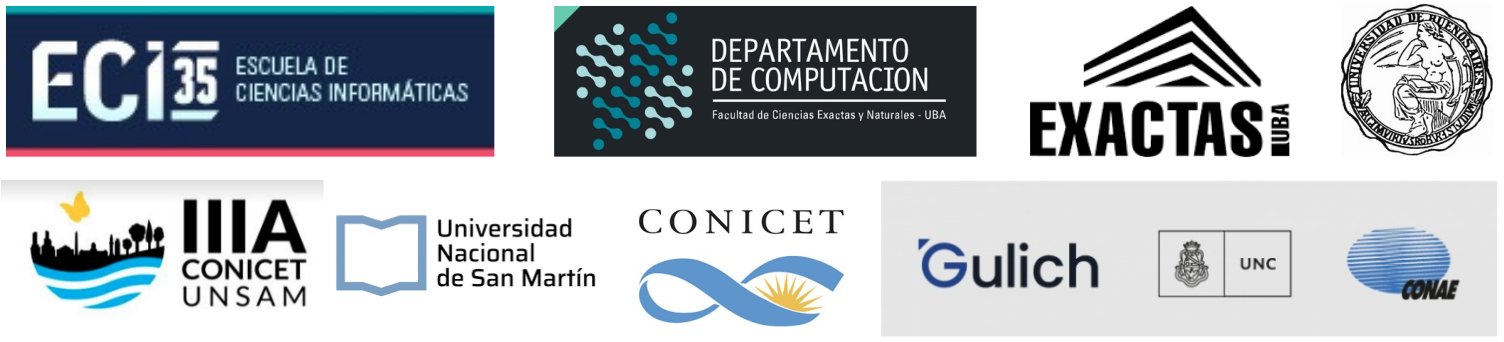
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 11: Aprendizaje no supervisado. Clustering
---
Lo que veremos en esta notebook:

- [x] Técnicas de clustering aplicadas a imágenes satelitales

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools
from scipy import linalg
from sklearn.metrics import confusion_matrix


import rasterio
import rasterio.mask


from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping

import pandas as pd
import seaborn as sns

from funciones import *

In [ ]:
path_proc = 'data/proc/'
path_out = 'data/out/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
    
# Guardo los datos espectrales, descarto la info espacial.
d,x,y = img.shape
X = img.reshape([d,x*y]).T

# Aprendizaje no-supervisado $\rightarrow$ _Clustering_

### Veremos dos métodos de clustering:
1. El clásico k-means
1. Una generalización llamada Gaussian Mixture Models

### Discutiremos brevemente el problema de la selección de modelos en este contexto


In [ ]:
from sklearn.cluster import KMeans

### Breve descripción del algoritmo iterativo: 
1. a cada dato le asigno su centroide más cecano
1. calcular centroides promediando 

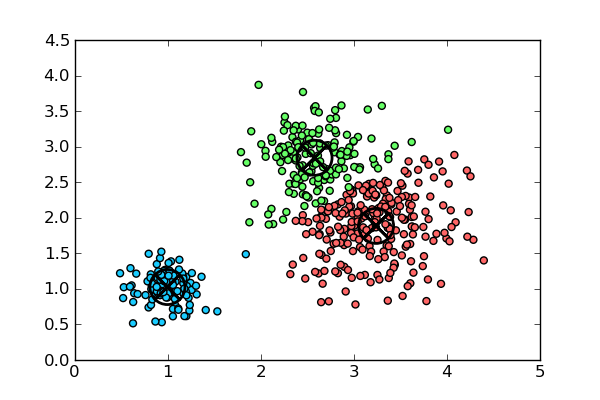

Más info en el Bishop, o en [Wikipedia](https://es.wikipedia.org/wiki/K-medias) y un [video](https://www.youtube.com/watch?v=5I3Ei69I40s) en la web.

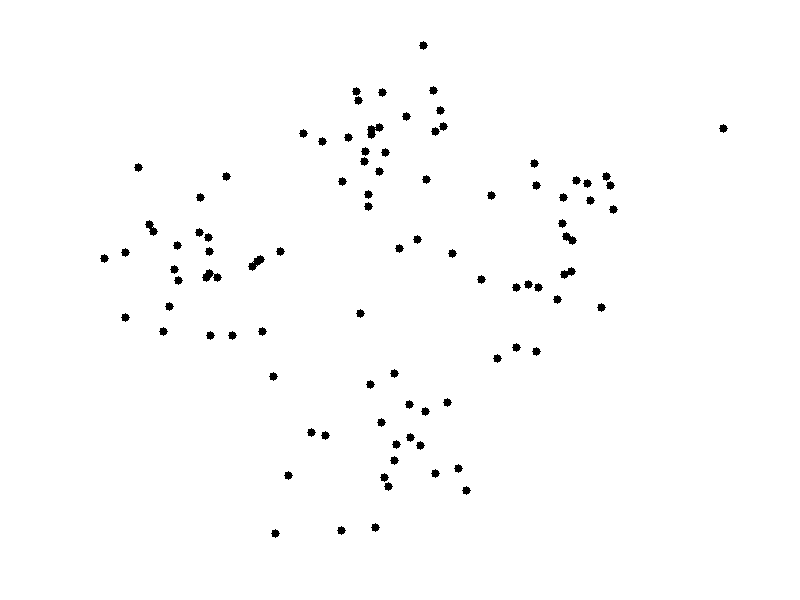


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
kmeans.labels_

In [ ]:
kmeans.cluster_centers_


In [ ]:
L = kmeans.labels_
Yimg = L.reshape([x,y])

In [ ]:
plt.figure(figsize=(15,10))
show(Yimg)
plt.show()

In [ ]:
N = 1000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,3], X[R,4], c=L[R], cmap='Spectral')
plt.show()

In [ ]:
X.shape

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
L = kmeans.labels_
Yimg = L.reshape([x,y])
plt.figure(figsize=(15,10))
show(Yimg)
plt.show()

In [ ]:
N = 1000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,3], X[R,4], c=L[R], cmap='Spectral')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
L = kmeans.labels_
Yimg = L.reshape([x,y])
plt.figure(figsize=(15,10))
show(Yimg)
plt.show()

In [ ]:
N = 1000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,2], X[R,3], c=L[R], cmap='Spectral')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)
L = kmeans.labels_
Yimg = L.reshape([x,y])
plt.figure(figsize=(15,10))
show(Yimg)
plt.show()

In [ ]:
N = 1000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,3], X[R,4], c=L[R], cmap='Spectral')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)
L = kmeans.labels_
Yimg = L.reshape([x,y])
plt.figure(figsize=(15,10))
show(Yimg)
plt.show()
#Yimg_kmeans6 = Yimg

In [ ]:
N = 10000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,3], X[R,4], c=L[R], cmap='Spectral')
plt.show()

In [ ]:
kmeans.cluster_centers_


## Limitaciones de K-means
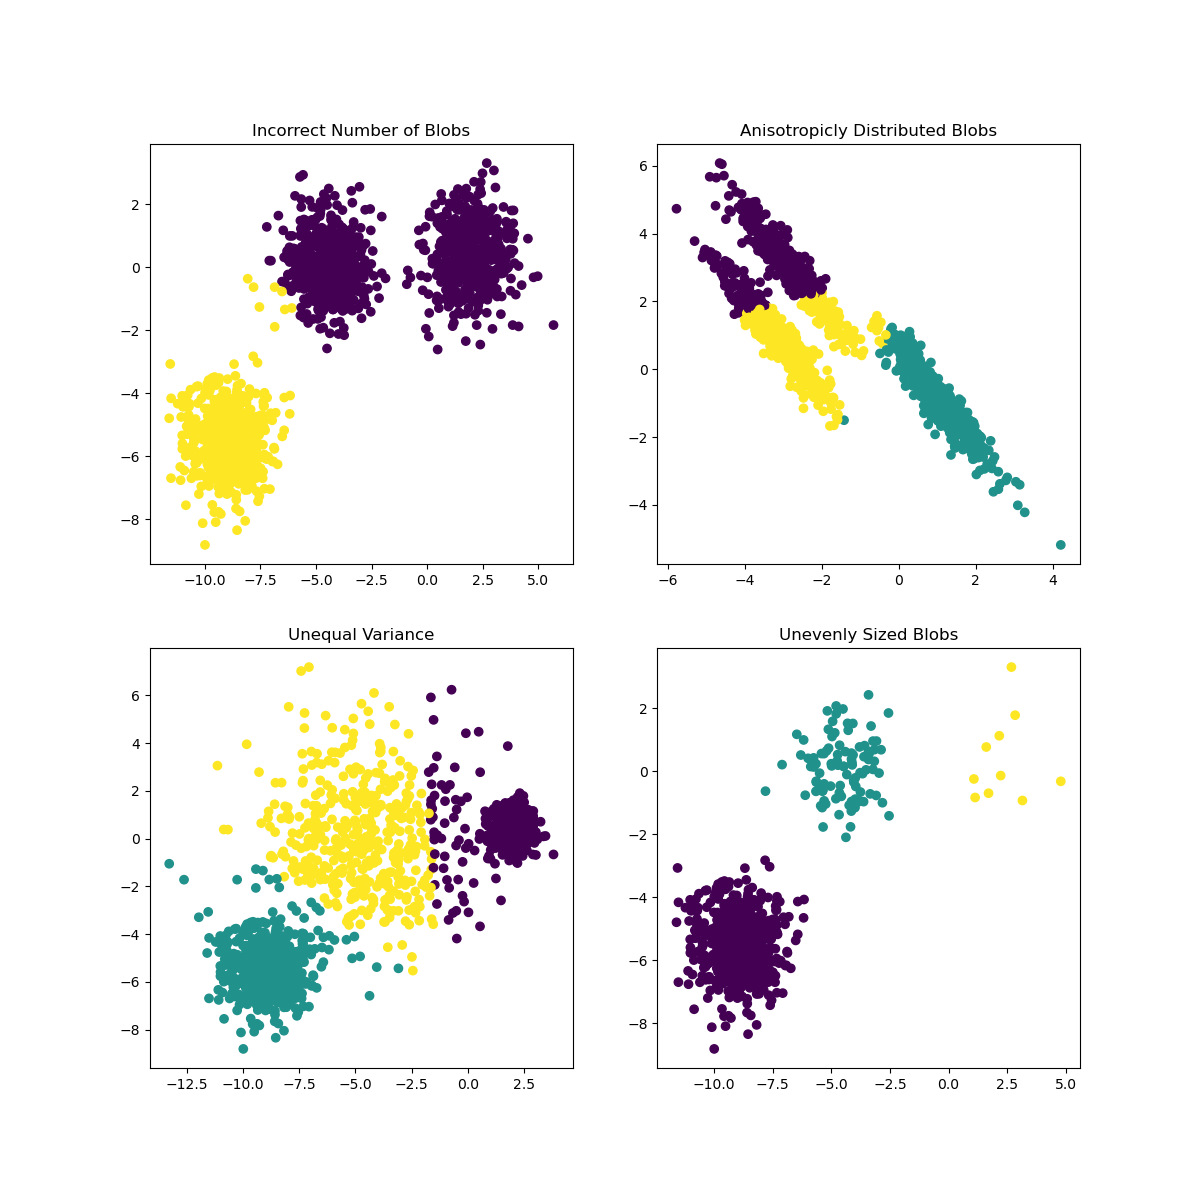

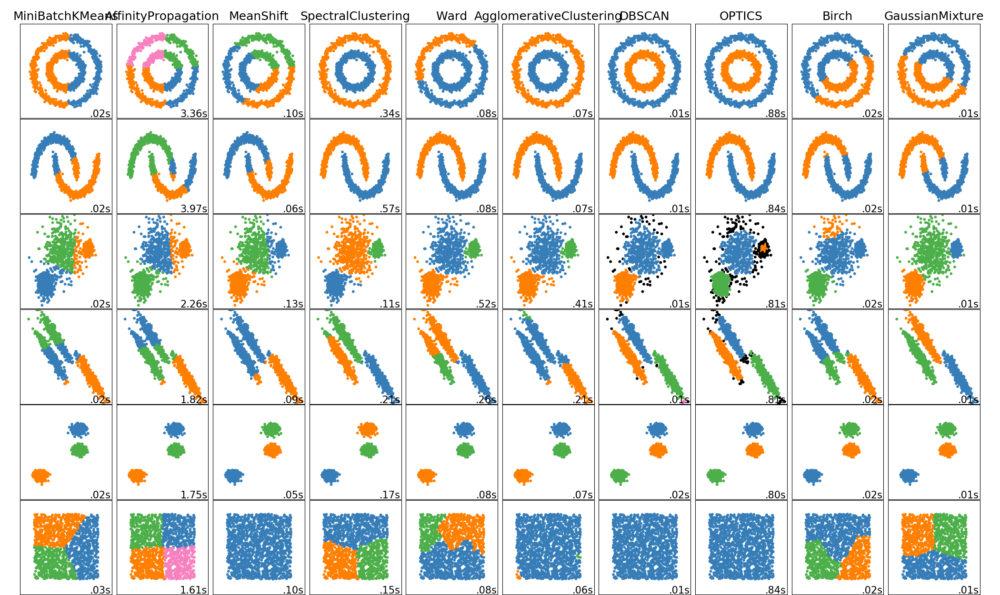

# Modelos de mezcla de Gaussianas

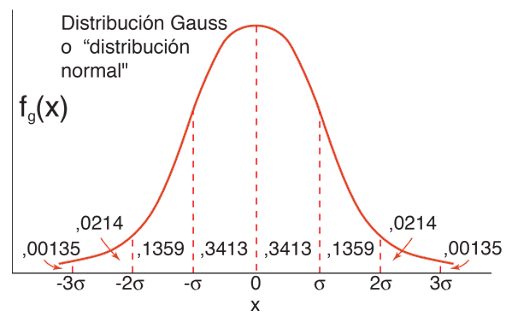

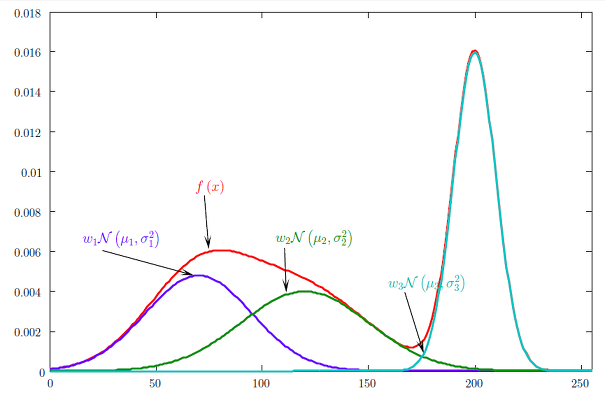

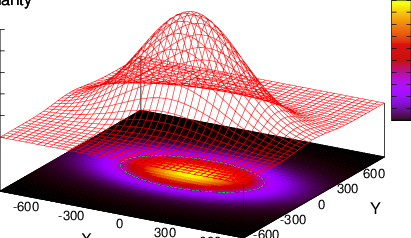

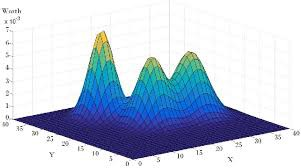

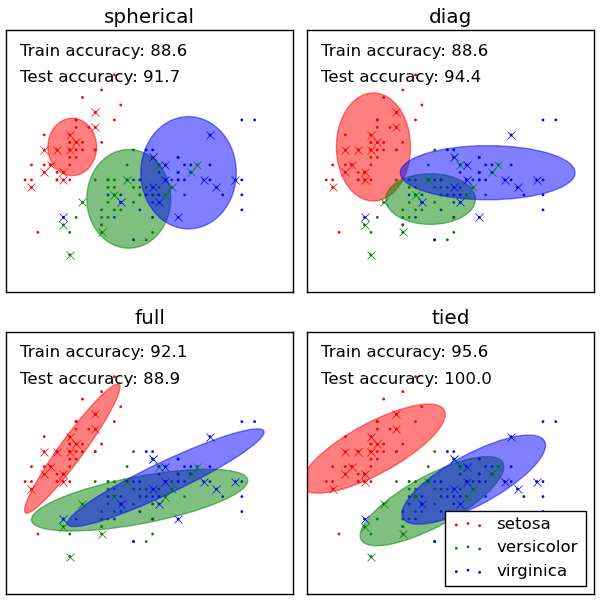

In [ ]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(X)

In [ ]:
Y_pred = gmm.predict(X)
Yimg = Y_pred.reshape([x,y])

In [ ]:
plt.figure(figsize=(15,10))
show(Yimg)

plt.show()

In [ ]:
plt.figure(figsize=(26,20),dpi=300)
show(Yimg,cmap='jet')
plt.show()

In [ ]:
guardar_GTiff(path_out + 'Dique_Clust_GMM6_IMG.tif',crs,gt,Yimg)
#%%

# Selección de modelos
Navaja de Occam: *en igualdad de condiciones, la explicación más simple suele ser la más probable*

## El criterio de información bayesino (BIC)

El criterio de información bayesiano (BIC) permite comparar y seleccionar entre modelos. Se basa, en la función de verosimilitud de un modelo y está relacionado con el Criterio de Información de Akaike (AIC).

Al usar modelos, es posible mejor el ajuste usando modelos más complejos, con más parámetros, pero está el riesgo de llegar a un sobreajuste. Tanto el BIC y AIC apuntar a encontrar un equilibrio mediante la introducción de un término de penalización para el número de parámetros en el modelo.

El BIC se define formalmente como:

### BIC = k.ln(n)-2.ln(L).


donde 

- L es el valor de verosimilitud del modelo;
- n = el número de datos u observaciones ;
- k = el número de parámetros libres a ser estimados en el modelo.


In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = [5, 40, 75]
cv_types = ['spherical','full']
print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        gmmbic = gmm.bic(X)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm


In [ ]:
bic

In [ ]:
lowest_bic

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
#%%
# Plot the winner
Y_pred = clf.predict(X)
Yimg = Y_pred.reshape([x,y])
#
plt.figure(figsize=(15,10))
show(Yimg,cmap='jet')
plt.show()
#
guardar_GTiff(path_out + 'Dique_Clust_GMMWin_IMG.tif',crs,gt,Yimg)

In [ ]:
N = 10000
R = np.random.randint(low=0, high=X.shape[0],size=N)#X.shape[0])
plt.figure(figsize=(15,10))
plt.scatter(X[R,4], X[R,3], c=Y_pred[R], cmap='Spectral')
plt.show()

### Ejercicio 11.1 USando el BIC

Usando el rectore `clip = img[:,200:400,200:400]` de la imagen levantada antes, corré un gmm con 10,20,30,40,50 y 60 clases con el modelo esférico y le modelo completo. Compará los resultados a partir del BIC. Seleccioná el mejor clustering, visualizá los resultados y guardalo como geotiff.